<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/education_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 教育スコア
- input
    - public_school_score.csv
        - 小学校スコア
        - 中学校スコア
    - library_score.csv
        - 図書館スコア
- output
    - education_score.csv
        - 教育スコア


In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
score_name = '教育スコア'
output_score_file = 'education_score.csv'

### 人口マスタ

In [6]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[[
    '地域ID', '市区町村名', '町名', '町丁目'
]].set_index('地域ID')
print(df_pop_master.shape)

(3145, 3)


### 学校スコア

In [7]:
df_school_score = pd.read_csv(os.path.join(DIR_NAME, 'public_school_score.csv'))[[
    '地域ID', '小学校スコア', '中学校スコア',
]].set_index('地域ID')
print(df_school_score.shape)

(3145, 2)


In [8]:
df_school_score.head()

,小学校スコア,中学校スコア
地域ID,,
101003,3.112,1.541
101004,2.518,1.546
101005,2.438,1.609
101007,2.692,1.919
101008,3.768,1.583


### 図書館

In [9]:
df_library_score = pd.read_csv(os.path.join(DIR_NAME, 'library_score.csv'))[[
    '地域ID', '図書館スコア'
]].set_index('地域ID')
print(df_library_score.shape)

(3145, 1)


In [10]:
df_library_score.head()

,図書館スコア
地域ID,
101003,0.991
101004,0.942
101005,1.280
101007,2.365
101008,2.301


In [11]:
def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

### 教育スコア

In [12]:
df_score = pd.concat([
    df_pop_master,
    df_school_score,
    df_library_score
], axis=1)
print(df_score.shape)
assert len(df_score) == len(df_pop_master)
df_pop_master = df_score

(3145, 6)


In [13]:
print(df_pop_master.shape)
df_pop_master.head()

(3145, 6)


,市区町村名,町名,町丁目,小学校スコア,中学校スコア,図書館スコア
地域ID,,,,,,
101003,千代田区,丸の内,丸の内１丁目,3.112,1.541,0.991
101004,千代田区,丸の内,丸の内２丁目,2.518,1.546,0.942
101005,千代田区,丸の内,丸の内３丁目,2.438,1.609,1.280
101007,千代田区,大手町,大手町１丁目,2.692,1.919,2.365
101008,千代田区,大手町,大手町２丁目,3.768,1.583,2.301


In [14]:
feature_list = {
    '小学校スコア': {'sort': 1, 'weight': 1},
    '中学校スコア': {'sort': 1, 'weight': 1},
    '図書館スコア': {'sort': 1, 'weight': 0.5},
}

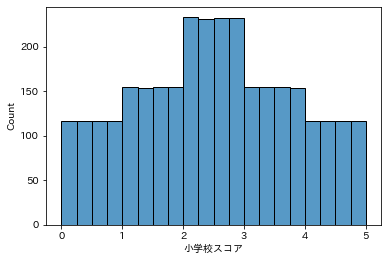

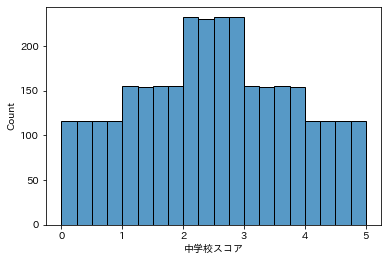

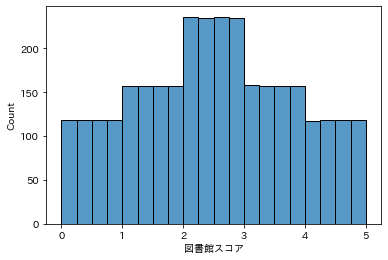

In [15]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

In [16]:
score_list = []
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = rank_score(df_pop_master[key] * value['sort'])
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_pop_master[score_name] = rank_score(_tmp_score)

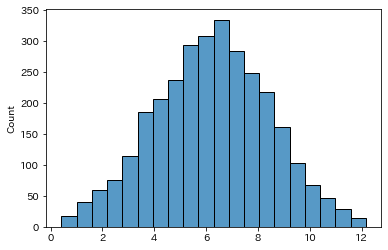

In [17]:
sns.histplot(_tmp_score, bins=20)
plt.show()

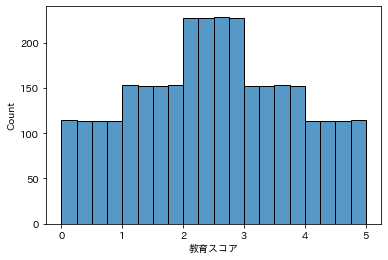

In [18]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [19]:
df_pop_master[score_name] = df_pop_master[score_name].round(3)

In [20]:
df_pop_master[
    list(feature_list.keys()) + [score_name]
].to_csv(os.path.join(DIR_NAME, output_score_file), index=True)

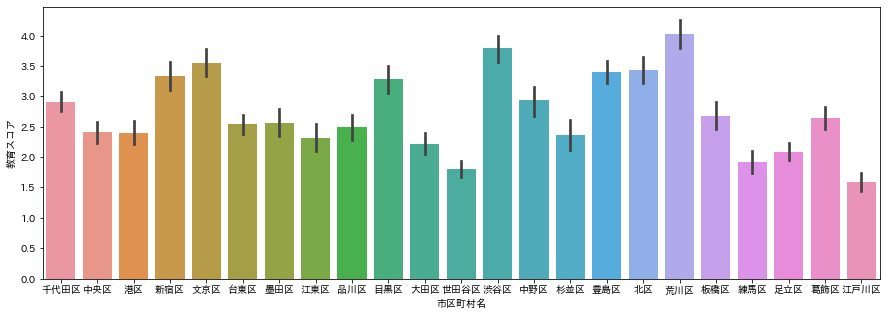

In [21]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_pop_master)
plt.show()

In [22]:
df_level = df_pop_master.copy()
df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目'] + list(feature_list.keys()) + [score_name]
].reset_index(drop=True)
print(df_level.shape)

(893, 7)


In [25]:
df_level.head(10)

,市区町村名,町名,町丁目,小学校スコア,中学校スコア,図書館スコア,教育スコア
0,北区,田端,田端５丁目,4.953,4.830,4.752,5.000
1,文京区,千石,千石２丁目,4.914,4.836,4.421,4.996
2,新宿区,北山伏町,北山伏町,4.970,4.994,3.935,4.993
3,新宿区,市谷山伏町,市谷山伏町,5.000,4.978,3.664,4.989
4,中野区,鷺宮,鷺宮３丁目,4.869,4.756,4.123,4.987
5,荒川区,西尾久,西尾久７丁目,4.522,4.791,4.720,4.985
6,北区,昭和町,昭和町３丁目,4.955,4.204,4.981,4.982
7,新宿区,市谷甲良町,市谷甲良町,4.978,4.948,3.421,4.980
8,渋谷区,鴬谷町,鴬谷町,4.509,4.976,4.297,4.978
9,新宿区,早稲田鶴巻町,早稲田鶴巻町,4.711,4.433,4.975,4.976


In [26]:
df_level.tail(10)

,市区町村名,町名,町丁目,小学校スコア,中学校スコア,図書館スコア,教育スコア
883,品川区,東八潮,東八潮,1.492,0.522,0.053,0.223
884,杉並区,松庵,松庵２丁目,0.835,0.145,2.030,0.214
885,大田区,城南島,城南島１丁目,0.713,0.977,0.028,0.153
886,練馬区,上石神井南町,上石神井南町,0.187,0.701,1.535,0.134
887,江東区,若洲,若洲１丁目,0.457,0.973,0.021,0.101
888,江戸川区,興宮町,興宮町,0.196,0.783,0.713,0.085
889,大田区,京浜島,京浜島１丁目,0.011,1.107,0.106,0.063
890,練馬区,西大泉町,西大泉町,0.136,0.822,0.079,0.035
891,世田谷区,砧公園,砧公園,0.047,0.390,0.964,0.028
892,葛飾区,水元公園,水元公園,0.237,0.201,0.414,0.009
